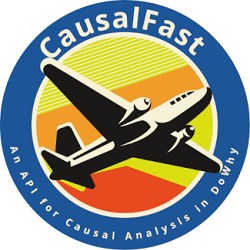
<h1>Titanic: ATE based on Propensity Score Matching</h1>

Propensity Score Matching can be used as a quasi-experimental method for causal analysis. The process is to split the sample into a treatment group and a control group. We then estimate the probability, based on covariate/confounder values, of an observation belonging to either the treatment or control group (without considering the outcome). These scores are generated by fitting a regression. Methods of calculating propensity scores include logistic regression or gradient boosting. If using logistic regression, categorical features must be converted to dummies. 

Our goal is to match similar propensity scores (predictions of receiving treatment based on covariates) between the treatment and control group. After matching, the distribution of our covariates should be very similar. We then take the standard mean difference of outcomes of the treatment group and the control group to estimate the average treatment effect (ATE). Using the Titanic dataset we will explore the effect of being in 3rd class on survival.

__[Source](https://towardsdatascience.com/propensity-score-matching-a0d373863eec)__ Code in this notebook was modified from the original, by Zolzaya Luvsandorj.
<br><br>
<h2>Step 1: Setup, EDA, Confounder Visualization</h2>


We can see the counfounders, gender and age, are distributed differently between the treatment (cabin class 3) and control groups (not cabin class 3)

---

In [1]:
import causalfast as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
cf.__version__

'0.2.9'

In [2]:
TREATMENT = 'class_3'
OUTCOME = 'survived'
titanicdata = pd.read_csv('https://raw.githubusercontent.com/TejuOye/CausalFast/main/api/data/titanic.csv')
titanicdata[TREATMENT] = (titanicdata['pclass']==3)
titanicdata['is_female'] = (titanicdata['sex']=='female')
print('Dimensions:',titanicdata.shape)
titanicdata.head(4)

Dimensions: (891, 14)


,passenger,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,class_3,is_female
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,True,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,True,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,True


In [3]:
df = titanicdata.filter([OUTCOME, TREATMENT, 'is_female', 'age']).dropna().reset_index(drop=True).astype('int64')
print('Dimensions:',df.shape)
print('Class 3 Population:     ',df[TREATMENT].value_counts()[1])
print('Class 3 Survived:       ',df.groupby(TREATMENT)[OUTCOME].value_counts()[1][1])
print('Not Class 3 Population: ',df[TREATMENT].value_counts()[0])
print('Not Class 3 Survived:   ',df.groupby(TREATMENT)[OUTCOME].value_counts()[0][1])
df.head(4)

Dimensions: (714, 4)
Class 3 Population:      355
Class 3 Survived:        85
Not Class 3 Population:  359
Not Class 3 Survived:    205


,survived,class_3,is_female,age
0,0,1,0,22
1,1,0,1,38
2,1,1,1,26
3,1,0,1,35


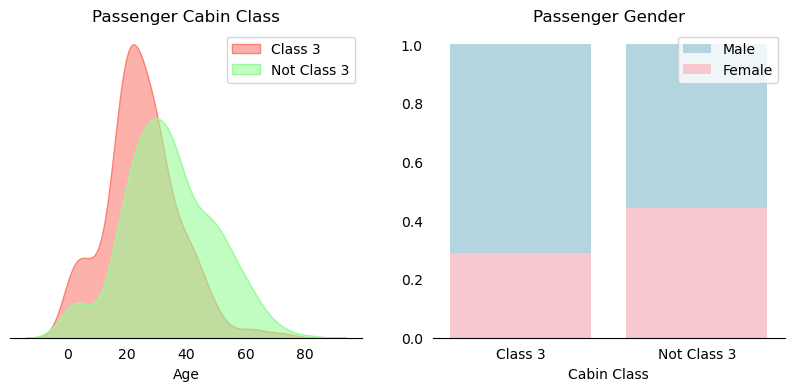

In [4]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.kdeplot(data=df[df[TREATMENT]==1], x='age', fill=True, color='salmon',
   alpha=.6, linewidth=1, label='Class 3', ax=ax[0])
sns.kdeplot(data=df[df[TREATMENT]==0], x='age', fill=True, color='palegreen',
   alpha=.6, linewidth=1, label='Not Class 3', ax=ax[0])
ax[0].tick_params(bottom=False, left=False),sns.despine(left=True),ax[0].legend(),
ax[0].set_xlabel('Age'),ax[0].set_ylabel(''),ax[0].set_title('Passenger Cabin Class');
ax[0].get_yaxis().set_visible(False)

gender = pd.crosstab(df[TREATMENT].replace({1:'Class 3',0:'Not Class 3'}),df['is_female'],normalize='index')
gender['both'] = 1
sns.barplot(data=gender, x=gender.index.astype(str),y="both",color='lightblue',label='Male', ax=ax[1])
sns.barplot(data=gender, x=gender.index.astype(str),y=1,color='pink',label='Female', ax=ax[1])
ax[1].tick_params(bottom=False, left=False),sns.despine(left=True),ax[1].legend(),
ax[1].set_xlabel('Cabin Class'),ax[1].set_ylabel(''),ax[1].set_title('Passenger Gender');

<br>
<h2>Step 2: CausalFast MakeGraph + Simulator</h2>

We generate a causal model in DoWhy and estimate propensity scores based on the causal graph.

---

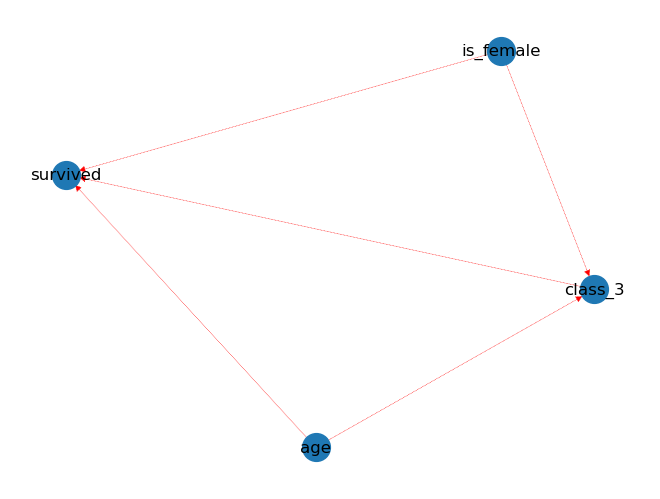

In [5]:
titanicedges = [('is_female','class_3'), 
                ('age','class_3'), 
                ('class_3','survived'), 
                ('age','survived'), 
                ('is_female','survived')]

titanicdigraph = cf.makegraph(function='makecausalmodel', 
                       eda = False, 
                       verbose=False, 
                       edges=titanicedges)


Returned: makecausalmodel[0] = CausalModel, makecausalmodel[1] = Digraph string, makecausalmodel[2] = dataset
Simulator Mode (Default DoWhy) Parameters: 
Identification Using: identifier=' default '
Estimation Using: method_name=' backdoor.propensity_score_matching '

Identify: 
Detected Estimand: backdoor - Estimation Options:
Note: method_name='default' uses 'backdoor.linear_regression' or 'backdoor.generalized_linear_model'
Note: method_name='default' override options include: 
   OLS Linear:  'backdoor.linear_regression'
   LogisticGLM: 'backdoor.generalized_linear_model'
   LogisticML:  'backdoor.econml.dr.LinearDRLearner'
   DoubleML:    'backdoor.econml.dml.DML'
   Propensity:  'backdoor.propensity_score_stratification'
   Propensity:  'backdoor.propensity_score_matching'
   Propensity:  'backdoor.propensity_score_weighting'

Note: Propensity Scores require both binary outcome and binary treatment variables
Note: generalized_linear_model (Logistic) & econml.dr.LinearDRLearner r

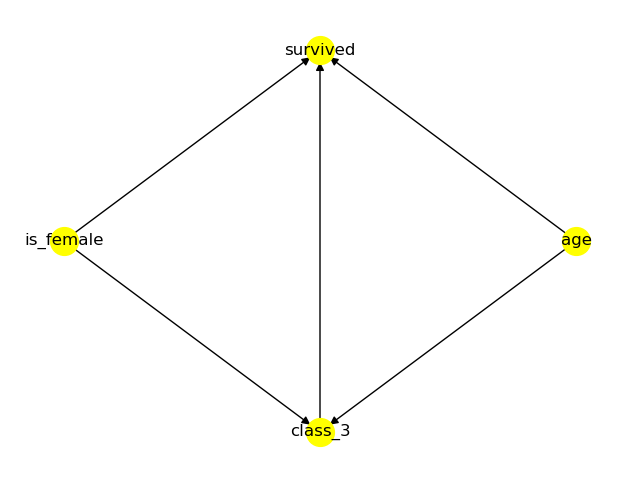

In [6]:
titanicmodel = cf.makegraph(function='makecausalmodel',
                           eda = False, 
                           verbose=False,
                           digraph=titanicdigraph,
                           dataset=df,
                           treatment=TREATMENT,
                           outcome=OUTCOME)

pscores = cf.simulator(causalmodel=titanicmodel[0], 
                       method_name='backdoor.propensity_score_matching', 
                       full_output=False, 
                       refute=False)

df = df.filter([OUTCOME, TREATMENT, 'is_female', 'age']).reset_index(drop=True)
df['DW_pscore'] = pscores[1]
df['DW_logit'] = df['DW_pscore'].apply(lambda p: np.log(p/(1-p)))
df['DW_predict'] = np.where(df['DW_pscore']>=0.5, 1, 0)

<br>
<h2>Optional: scikit-learn Propensity Score</h2>

We generate propensity scores using a logistic regression in scikit-learn. Notice the resulting scores are very similar. The propensity score itself is not a method used to predict the outcome. Rather it is a method of predicting receiving treatment based on covariates (not including outcome). However, we do compare the outcome with the predicted propensity score anyway.

---

In [7]:
from sklearn.linear_model import LogisticRegression
X = pd.get_dummies(df.filter(['is_female', 'age']))
T = df[TREATMENT]
lr = LogisticRegression(C=1e6)
lr.fit(X, T)
pred_prob = lr.predict_proba(X)
df['SK_pscore'] = lr.predict_proba(X)[:,1]
df['SK_logit'] = df['SK_pscore'].apply(lambda p: np.log(p/(1-p)))
df['SK_predict'] = np.where(df['SK_pscore']>=0.5, 1, 0)
df

,survived,class_3,is_female,age,DW_pscore,DW_logit,DW_predict,SK_pscore,SK_logit,SK_predict
0,0,1,0,22,0.667964,0.698990,1,0.670296,0.709526,1
1,1,0,1,38,0.265685,-1.016626,0,0.262191,-1.034613,0
2,1,1,1,26,0.404277,-0.387674,0,0.400482,-0.403456,0
3,1,0,1,35,0.297467,-0.859388,0,0.293836,-0.876824,0
4,0,1,0,35,0.504406,0.017625,1,0.506443,0.025773,1
...,...,...,...,...,...,...,...,...,...,...
709,0,1,1,39,0.255586,-1.069039,0,0.252144,-1.087209,0
710,0,0,0,27,0.607526,0.436926,1,0.609817,0.446544,1
711,1,0,1,19,0.494804,-0.020785,0,0.491180,-0.035282,0
712,1,0,0,26,0.619951,0.489339,1,0.622257,0.499140,1


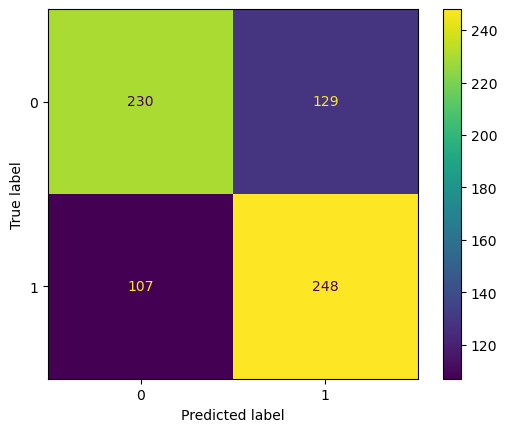

Accuracy Score: 0.6694677871148459
ROC AUC: 0.71989485660481
F1-Score: 0.6775956284153005


In [8]:
from sklearn.metrics import roc_auc_score, f1_score, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(df[TREATMENT],df['DW_predict'])
plt.show()
print('Accuracy Score:',np.mean(df[TREATMENT]==df['DW_predict']))
print('ROC AUC:',roc_auc_score(df[TREATMENT], df['DW_pscore']))
print('F1-Score:',f1_score(df[TREATMENT], df['DW_predict']))

<br>
<h2>Step 4: Propensity Score Matching</h2>

There are different packages and methods that can be used for propensity score matching. This is a basic algorithm for matching scores. 

---

In [12]:
MATCHCOL = 'DW_pscore'    # 'DW_pscore' 'DW_logit' 'SK_pscore' 'SK_logit'
df.sort_values(MATCHCOL, inplace=True)
n = len(df)-1
for i, (ind, row) in enumerate(df.iterrows()): 
    if row[TREATMENT]:    
        if i<n:
            above = df.iloc[i:]
            control_above = above[above[TREATMENT]==0]
            match_above = control_above.iloc[0]
            distance_above = match_above[MATCHCOL] - row[MATCHCOL]
            df.loc[ind, 'match'] = match_above.name
            df.loc[ind, 'distance'] = distance_above
        if i>1:
            below = df.iloc[:i-1]
            control_below = below[below[TREATMENT]==0]
            match_below = control_below.iloc[-1]
            distance_below = match_below[MATCHCOL] - row[MATCHCOL]
            if i==n:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below
            elif distance_below<distance_above:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below
indices = df[df['match'].notna()].index.append(pd.Index(df.loc[df['match'].notna(), 'match']))
matched_df = df.loc[indices].reset_index(drop=True)
print('Dimensions:',matched_df.shape)
print('Class 3 Population:     ',matched_df[TREATMENT].value_counts()[1])
print('Not Class 3 Population: ',matched_df[TREATMENT].value_counts()[0])
matched_df

Dimensions: (710, 12)
Class 3 Population:      355
Not Class 3 Population:  355


,survived,class_3,is_female,age,DW_pscore,DW_logit,DW_predict,SK_pscore,SK_logit,SK_predict,match,distance
0,1,1,1,63,0.088916,-2.326943,0,0.087104,-2.349522,0,221.0,0.000000
1,0,1,0,74,0.116452,-2.026470,0,0.116553,-2.025485,0,216.0,-0.003894
2,0,1,0,70,0.139816,-1.816820,0,0.140023,-1.815100,0,617.0,-0.004556
3,0,1,0,65,0.174400,-1.554756,0,0.174781,-1.552118,0,633.0,-0.005461
4,0,1,1,48,0.176426,-1.540753,0,0.173564,-1.560576,0,366.0,-0.002025
...,...,...,...,...,...,...,...,...,...,...,...,...
705,1,0,0,2,0.851605,1.747244,1,0.853392,1.761453,1,NaN,NaN
706,1,0,0,2,0.851605,1.747244,1,0.853392,1.761453,1,NaN,NaN
707,1,0,0,1,0.858107,1.799656,1,0.859851,1.814049,1,NaN,NaN
708,1,0,0,1,0.858107,1.799656,1,0.859851,1.814049,1,NaN,NaN


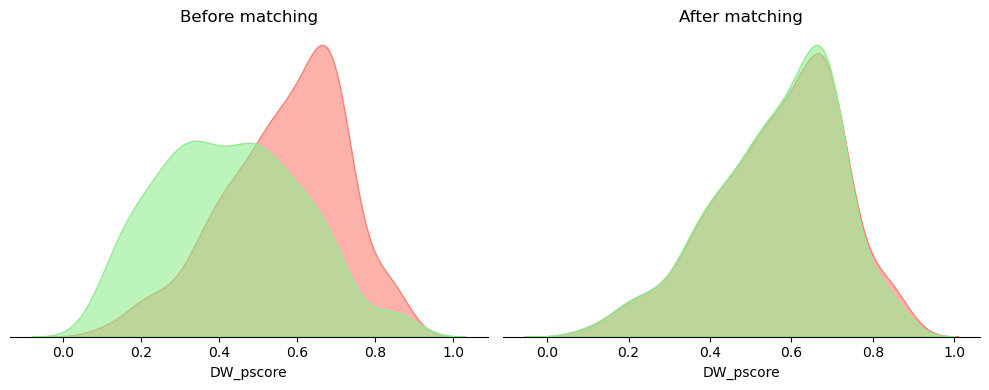

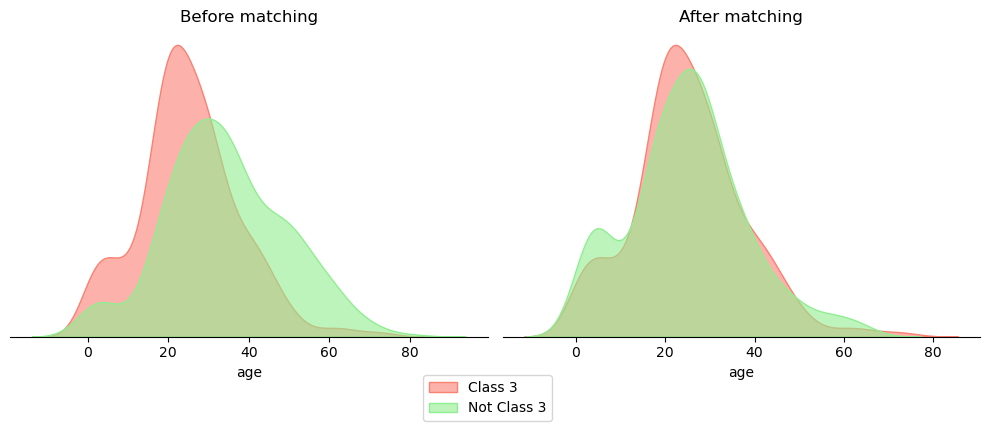

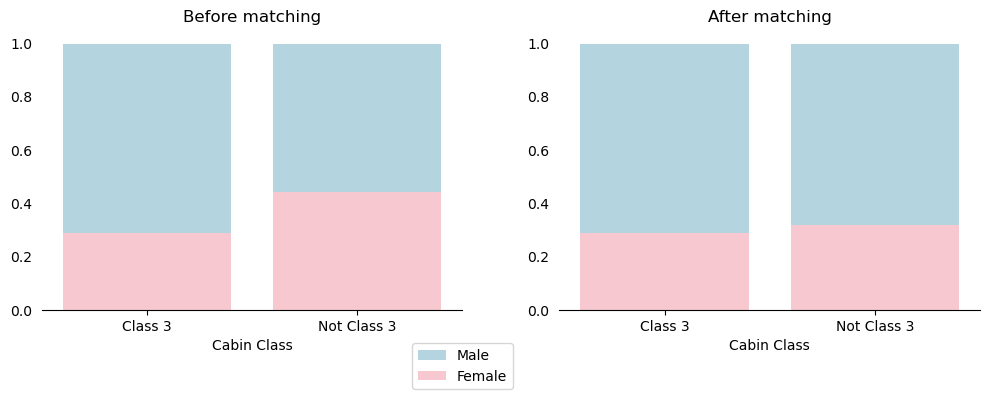

In [13]:
for var in [MATCHCOL, 'age']:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    sns.kdeplot(data=df[df[TREATMENT]==1], x=var, fill=True, color='salmon',
                alpha=.6, linewidth=1, label='Class 3', ax=ax[0])
    sns.kdeplot(data=df[df[TREATMENT]==0], x=var, fill=True, color='lightgreen',
                alpha=.6, linewidth=1, label='Not Class 3', ax=ax[0])
    ax[0].set_title('Before matching'),ax[0].get_yaxis().set_visible(False)
    sns.kdeplot(data=matched_df[matched_df[TREATMENT]==1], x=var, fill=True, color='salmon',
                alpha=.6, linewidth=1, label='Class 3')
    sns.kdeplot(data=matched_df[matched_df[TREATMENT]==0], x=var, fill=True, color='lightgreen',
                alpha=.6, linewidth=1, label='Not Class 3')
    ax[1].set_title('After matching'),ax[1].get_yaxis().set_visible(False),plt.tight_layout(),sns.despine(left=True)
ax[0].legend(loc='center', bbox_to_anchor=(1.0, -0.2));
    
gender_after = pd.crosstab(matched_df[TREATMENT].replace({1: 'Class 3', 0: 'Not Class 3'}),matched_df['is_female'],normalize='index')
gender_after['both'] = 1
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(data=gender, x=gender.index.astype(str), y="both", color='lightblue', label='Male', ax=ax[0])
sns.barplot(data=gender, x=gender.index.astype(str), y=1, color='pink', label='Female', ax=ax[0])
ax[0].set_xlabel('Cabin Class'),ax[0].set_ylabel(''),ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
ax[0].set_title('Before matching'),plt.tight_layout(),sns.despine(left=True),ax[0].tick_params(left=False)
sns.barplot(data=gender_after, x=gender_after.index.astype(str), y="both", color='lightblue', label='Male', ax=ax[1])
sns.barplot(data=gender_after, x=gender_after.index.astype(str), y=1, color='pink', label='Female', ax=ax[1])
ax[1].set_xlabel('Cabin Class'),ax[1].set_ylabel(''),ax[0].legend(loc='center', bbox_to_anchor=(1.0, -0.2))
ax[1].set_title('After matching'),plt.tight_layout(),sns.despine(left=True),ax[1].tick_params(left=False);

In [11]:
summary = matched_df.groupby(TREATMENT)[OUTCOME].aggregate(['mean', 'std', 'count'])
control_outcome = summary.loc[0, 'mean']
treatment_outcome =  summary.loc[1, 'mean']
att = treatment_outcome - control_outcome
print('Control Group Outcome:   ',control_outcome)
print('Treatment Group Outcome: ',treatment_outcome)
print('Average Treatment Effect on Treated (ATT):',att)
summary

Control Group Outcome:    0.5183098591549296
Treatment Group Outcome:  0.23943661971830985
Average Treatment Effect on Treated (ATT): -0.2788732394366197


,mean,std,count
class_3,,,
0,0.518310,0.500370,355
1,0.239437,0.427342,355
